In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nba-draft-picks-200917/nba_draft_combine_all_years.csv


**PREDICTING NBA DRAFT PICKS BASED ON PHYSICAL CHARACTERISTICS USING LASSO REGRESSION**

In [68]:
df = pd.read_csv('../input/nba-draft-picks-200917/nba_draft_combine_all_years.csv')
df.head()

,Unnamed: 0,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,0,Blake Griffin,2009,1.0,80.50,82.00,83.25,105.0,35.5,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,1,Terrence Williams,2009,11.0,77.00,78.25,81.00,103.5,37.0,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,2,Gerald Henderson,2009,12.0,76.00,77.00,82.25,102.5,35.0,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,3,Tyler Hansbrough,2009,13.0,80.25,81.50,83.50,106.0,34.0,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,4,Earl Clark,2009,14.0,80.50,82.25,86.50,109.5,33.0,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                517 non-null    int64  
 1   Player                    517 non-null    object 
 2   Year                      517 non-null    int64  
 3   Draft pick                384 non-null    float64
 4   Height (No Shoes)         517 non-null    float64
 5   Height (With Shoes)       516 non-null    float64
 6   Wingspan                  517 non-null    float64
 7   Standing reach            517 non-null    float64
 8   Vertical (Max)            450 non-null    float64
 9   Vertical (Max Reach)      450 non-null    float64
 10  Vertical (No Step)        450 non-null    float64
 11  Vertical (No Step Reach)  450 non-null    float64
 12  Weight                    516 non-null    float64
 13  Body Fat                  514 non-null    float64
 14  Hand (Leng

Let us get an understanding of the data by plotting a graph.

<AxesSubplot:xlabel='Wingspan', ylabel='Draft pick'>

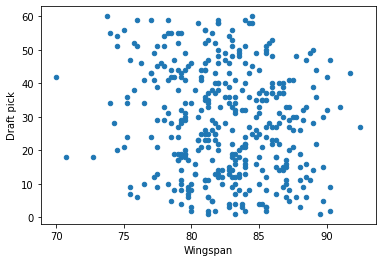

In [70]:
df.plot.scatter(x='Wingspan',y='Draft pick')

In [71]:
df.shape


(517, 19)

In [72]:
df.isnull().sum()

Unnamed: 0                    0
Player                        0
Year                          0
Draft pick                  133
Height (No Shoes)             0
Height (With Shoes)           1
Wingspan                      0
Standing reach                0
Vertical (Max)               67
Vertical (Max Reach)         67
Vertical (No Step)           67
Vertical (No Step Reach)     67
Weight                        1
Body Fat                      3
Hand (Length)                47
Hand (Width)                 49
Bench                       233
Agility                      73
Sprint                       71
dtype: int64

In [73]:
df.columns

Index(['Unnamed: 0', 'Player', 'Year', 'Draft pick', 'Height (No Shoes)',
       'Height (With Shoes)', 'Wingspan', 'Standing reach', 'Vertical (Max)',
       'Vertical (Max Reach)', 'Vertical (No Step)',
       'Vertical (No Step Reach)', 'Weight', 'Body Fat', 'Hand (Length)',
       'Hand (Width)', 'Bench', 'Agility', 'Sprint'],
      dtype='object')

We plan to use player height, weight, wingspan, reach and body fat to predict the draft picks of any given player. Also, since many players in our datasets have no draft pick values as a result of their going undrafted, we replace all their draft pick values with 61 (60 is the highest possible value according to our dataset).

In [74]:
df['Draft pick']=df['Draft pick'].fillna(61)
df.tail()

,Unnamed: 0,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
512,512,Peter Jok,2017,61.0,76.25,77.75,80.00,102.0,31.0,133.0,26.5,128.5,202.0,11.0,8.25,9.50,NaN,11.34,3.41
513,513,Rawle Alkins,2017,61.0,74.50,75.75,80.75,99.0,40.5,139.5,31.5,130.5,223.0,11.0,8.75,10.00,NaN,11.99,3.30
514,514,Sviatoslav Mykhailiuk,2017,61.0,78.50,79.50,77.00,100.0,33.0,133.0,27.0,127.0,220.0,11.4,8.00,9.25,NaN,12.40,3.53
515,515,Thomas Welsh,2017,61.0,83.50,84.50,84.00,109.5,NaN,NaN,NaN,NaN,254.0,10.9,9.00,10.50,NaN,NaN,NaN
516,516,V.J. Beachem,2017,61.0,78.25,80.00,82.25,104.5,37.0,141.5,30.0,134.5,193.0,6.8,8.50,9.00,NaN,11.18,3.26


In [75]:
X=df[['Height (No Shoes)','Wingspan', 'Standing reach','Weight','Body Fat']]
y=df['Draft pick']
X.head()


,Height (No Shoes),Wingspan,Standing reach,Weight,Body Fat
0,80.50,83.25,105.0,248.0,8.2
1,77.00,81.00,103.5,213.0,5.1
2,76.00,82.25,102.5,215.0,4.4
3,80.25,83.50,106.0,234.0,8.5
4,80.50,86.50,109.5,228.0,5.2


In [76]:
y.head()

0     1.0
1    11.0
2    12.0
3    13.0
4    14.0
Name: Draft pick, dtype: float64

We still have missing values in a few columns. We impute to replace missing values with the mean value of the particular column.

In [77]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer()
imp_X=pd.DataFrame(imp.fit_transform(X))
imp_X.columns=X.columns
imp_X.isnull().sum()

Height (No Shoes)    0
Wingspan             0
Standing reach       0
Weight               0
Body Fat             0
dtype: int64

Now that we have no null values, we begin training our model. We split our data into train and test values

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imp_X, y, test_size=0.33, random_state=42)

In [79]:
from sklearn.linear_model import Lasso
reg=Lasso(alpha=0.1)
reg.fit(X_train,y_train)
res=reg.predict(X_test)
res=res.round()

In [80]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(res,y_test)

16.900584795321638

We obtain a mean absolute error of ~17 for each prediction. This means our player is about 17 picks off his actual position in the draft combine! Since there are multiple factors leading to a team picking a particular player for their team (team requirements,team culture,etc), including many intangibles picked up by scouts (motivation,drive,etc), we can conclude that it is near impossible to predict a prospect's draft pick from merely their physical attributes.